# CPSC 533R Visual AI - Assignment 1

In [171]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

In [172]:
# define a target device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device='cpu'
print(device)

cpu


In [173]:
# define a wrapper of a given dataset
class myMNIST_wrapper(torch.utils.data.Dataset):
  def __init__(self, *args, **kwargs):
    self.ds = torchvision.datasets.MNIST(*args, **kwargs)
    print('The dataset is initialized.')

  def __getitem__(self,index):
    img1, label1 = self.ds[index]
    index2 = torch.randint(0, len(self.ds), [1], dtype=torch.int).item()
    img2, label2 = self.ds[index2]
    # return dict(img, self.ds[index])
    if label1 == label2:
      # matching_class_label = torch.ones(1, dtype=torch.bool)
      matching_class_label = torch.ones(1)
    else:
      # matching_class_label = torch.zeros(1, dtype=torch.bool)
      matching_class_label = torch.zeros(1)
    return {'img1':img1, 'img2':img2, 'matching_pair':matching_class_label}

  def __len__(self):
    return len(self.ds)

  # # Task IV: return two images and a binary variable
  # def pairs(self, index1, index2):
  #   img1, label1 = self.ds[index1]
  #   img2, label2 = self.ds[index2]
  #   if label1 == label2:
  #     matching_class_label = 1
  #   else:
  #     matching_class_label = 0
  #   return {'img1':img1, 'img2':img2, 'matching_pair':matching_class_label}

In [174]:
# Use standard FashionMNIST dataset
def gray_to_color(x):
    return x.repeat(3, 1, 1)

#train_set = torchvision.datasets.FashionMNIST(
train_set = myMNIST_wrapper(
    root = './DatasetFashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        #gray_to_color,
    ])
)

train_loader = torch.utils.data.DataLoader(train_set, shuffle=False, 
                      batch_size = 7, 
                      pin_memory=False,
                      drop_last=False)

The dataset is initialized.


The two images are: tensor([1.])
The shape of the first image is:  torch.Size([1, 28, 28])
The shape of the second image is:  torch.Size([1, 28, 28])


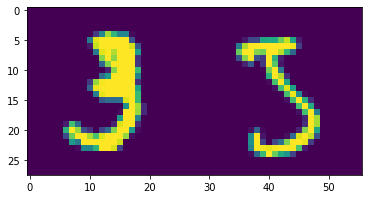

In [175]:
import matplotlib.pyplot as plt

idx  = 10
sample  = train_set[idx]
# for i,v in enumerate(sample):
#   if isinstance(v,torch.Tensor):
#     print(i,v.shape)
#   else:
#     print(i,v)

print("The two images are:", sample['matching_pair'])
print("The shape of the first image is: ", sample['img1'].shape)
print("The shape of the second image is: ", sample['img2'].shape)
plt.imshow(torch.cat([sample['img1'][0],
          sample['img2'][0]],dim=1).numpy().squeeze())

In [176]:
# get a batch
iterator = iter(train_loader)
batch = next(iterator)

print(torch.cat([batch['img1'], batch['img2']], dim=2).shape)
print(batch['img1'].shape)
print(batch['img2'].shape)
print(batch['matching_pair'].shape)
print(batch['matching_pair'])
print(batch['matching_pair'].to(device))

torch.Size([7, 1, 56, 28])
torch.Size([7, 1, 28, 28])
torch.Size([7, 1, 28, 28])
torch.Size([7, 1])
tensor([[0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.]])
tensor([[0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.]])


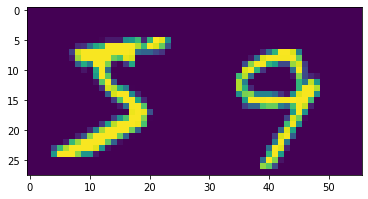

In [177]:
plt.imshow(torch.cat([batch['img1'][0],
          batch['img2'][0]],dim=2).cpu().numpy().squeeze())

In [183]:
# define a model from scratch:
class myNN(nn.Module):
  def __init__(self, in_features=28*56, latent_dim= 128, out_dim=2, activation_layer=nn.ReLU()):
    # define a simple structure
    super().__init__()
    
    self.in_features = in_features
    self.out_dim = out_dim
    self.latent_dim = latent_dim
    self.activation_layer = activation_layer

    self.fc = nn.Sequential(
            nn.Linear(in_features=self.in_features, out_features=self.latent_dim*4),
            self.activation_layer,
            nn.Linear(in_features=self.latent_dim*4, out_features=self.latent_dim*2),
            self.activation_layer,
            nn.Linear(in_features=self.latent_dim*2, out_features=self.latent_dim),
            self.activation_layer,
            nn.Linear(in_features=self.latent_dim, out_features=self.out_dim),
        )
  def forward(self, batch):
    # print(batch.shape)
    x = batch.flatten(start_dim=1,end_dim=-1)
    # print(x.shape)
    x = self.fc(x)
    # print(x.shape)

    return x

# define a wrapper for myNN which takes a dict batch
class myNN_dict(myNN):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

    # # add a layer to the top
    # fc_layers = list(self.fc)
    # fc_layers.insert(1,nn.Dropout(p=0.5))
    # self.fc = nn.Sequential(*fc_layers)
  
  # Task II: select input from a dictionary
  def forward(self, input_dict):
    y = torch.cat([input_dict['img1'], input_dict['img2']], dim=2)
    # print("attemp1: ", y.shape)
    y = super().forward(y)
    # print("attemp2: ", y.shape)
    y = torch.sigmoid(y)
    return {'prob':y}

In [ ]:
# def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
#     """3x3 convolution with padding"""
#     return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
#                      padding=dilation, groups=groups, bias=False, dilation=dilation)

# class BasicBlock(nn.Module):
#     expansion = 1

#     def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
#                  base_width=64, dilation=1, norm_layer=None):
#         super(BasicBlock, self).__init__()
#         if norm_layer is None:
#             norm_layer = nn.BatchNorm2d
#         if groups != 1 or base_width != 64:
#             raise ValueError('BasicBlock only supports groups=1 and base_width=64')
#         if dilation > 1:
#             raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
#         # Both self.conv1 and self.downsample layers downsample the input when stride != 1
#         self.conv1 = conv3x3(inplanes, planes, stride)
#         self.bn1 = norm_layer(planes)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = conv3x3(planes, planes)
#         self.bn2 = norm_layer(planes)
#         self.downsample = downsample
#         self.stride = stride

#     def forward(self, x):
#         identity = x

#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)

#         out = self.conv2(out)
#         out = self.bn2(out)

#         if self.downsample is not None:
#             identity = self.downsample(x)

#         out += identity
#         out = self.relu(out)

#         return out

# class myNN_dict(torchvision.models.ResNet):
#   def __init__(self, *args, **kwargs):
#     super().__init__(*args, **kwargs)

#   # Task II: select input from a dictionary
#   def forward(self, input_dict):
#     y = torch.cat([sample['img1'], sample['img2']], dim=2)
#     y = super().forward(y)
#     y = torch.sigmoid(y)
#     return {'prob':y}

In [184]:
# mylayers = [2,2,2,2]
# model = myNN_dict(BasicBlock, mylayers)
model = myNN_dict()
# model_2.eval()
model.train()
result = model(batch)
print(result)

{'prob': tensor([[0.5064, 0.4802],
        [0.5039, 0.4815],
        [0.5010, 0.4849],
        [0.5045, 0.4831],
        [0.5036, 0.4863],
        [0.5076, 0.4827],
        [0.5045, 0.4836]], grad_fn=<SigmoidBackward>)}


In [185]:
network = myNN_dict()

In [186]:
losses = []
criterion = torch.nn.CrossEntropyLoss()
iterator = iter(train_loader)
optimizer = optim.SGD(network.parameters(), lr=0.001)
for i in range(200): #range(len(loader)):
    batch = next(iterator)
    # Task III: modify the loss function
    preds = network(batch)
    loss = criterion(preds['prob'], batch['matching_pair'][:,0].long())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if i%10==0:
        print(i,losses[-1])

0 0.6986017227172852
10 0.7028383612632751
20 0.6986261010169983
30 0.6943235993385315
40 0.6990185976028442
50 0.704890251159668
60 0.7039996385574341
70 0.7012587785720825
80 0.7031732797622681
90 0.7007231116294861
100 0.7004412412643433
110 0.702926754951477
120 0.7015494704246521
130 0.6992436647415161
140 0.6991466283798218
150 0.6988160014152527
160 0.7003442645072937
170 0.6988807320594788
180 0.700887143611908
190 0.6980608105659485


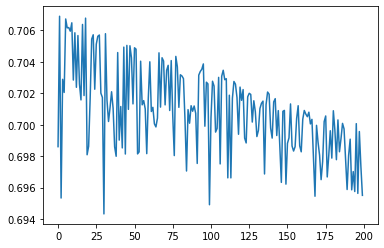

In [187]:
import matplotlib.pyplot as plt
plt.plot(losses)